In [1]:
# Some initializations
import numpy as np
import torch
import torchvision
from skimage import color
import random
import matplotlib.pyplot as plt
import matplotlib.colors as mpl_colors
from matplotlib import collections  as mc
from scipy.ndimage.measurements import center_of_mass

import sys
import os
import pprint
import pickle
import h5py
sys.path.append(os.path.abspath('../src/'))
sys.path.append(os.path.abspath('../src/scripts'))

import lib.utils as utils
from lib.data.worms_dataset import WormsDataset
from scripts.settings import Settings, DEFAULT_PATH
from consolidate_cpm_dataset import read_seghyp_names, helper_get_pm_and_acc

%matplotlib inline
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
from lib.data.labels import Labels
from lib.data.worms import Worms
ulabels_fn = os.path.abspath(
        os.path.join(DEFAULT_PATH.DATA, 'raw', '30WormsImagesGroundTruthSeg', 'universe.txt')
        )
ulabels = Labels(ulabels_fn)
worms = Worms(DEFAULT_PATH.WORM_NAMES)

raw_worms_dataset_root = os.path.abspath(
        os.path.join(DEFAULT_PATH.DATA, 'raw', '30WormsImagesGroundTruthSeg', )
        )
seghypnames_fn = os.path.join(raw_worms_dataset_root, 'groundTruthInstanceSeg',
                                  '{}.ano.curated.aligned.txt')

In [3]:
EXP_ROOT = '/home/ashkan/workspace/deployed/worms_nuclei_metric_learning-deployed/experiments/'
# EXP_ROOT += 'one_consistent-patch32-skip_large_loss'
EXP_ROOT += 'patch32-skip_large_loss'


STEP = 100000

X_SLICES = [70]
Z_MIN=0
Z_MAX=1400

WORMS = [1, 2]

pm_file = os.path.join(EXP_ROOT, 'output', f'model-step={STEP}-cluster_predict_per_worm.pkl')
print(pm_file)
with open(pm_file, 'rb') as f:
    all_w2w_pm = pickle.load(f)

/home/ashkan/workspace/deployed/worms_nuclei_metric_learning-deployed/experiments/patch32-skip_large_loss/output/model-step=100000-cluster_predict_per_worm.pkl


In [4]:
def get_w2wpm_from_clusters(wuid1, wuid2):
    allworm_sl_2_cl = all_w2w_pm['allworm_seghyplabel_to_clusterlabel_dict']
    w1_sl_2_cl_dict = allworm_sl_2_cl[wuid1]
    w2_sl_2_cl_dict = allworm_sl_2_cl[wuid2]
    w2_cl_2_sl_dict = {v:k for k,v in w2_sl_2_cl_dict.items()}
    pm = {}
    for sl1, cl1 in w1_sl_2_cl_dict.items():
        if cl1 not in w2_cl_2_sl_dict.keys():
            continue
        pm.update({sl1:w2_cl_2_sl_dict[cl1]})
    return pm

In [5]:
def plot_pm(xslice, zmin, zmax, pm):
    wuid1 = WORMS[0]
    wuid2 = WORMS[1]

    if wuid2 < wuid1:
        wuid1, wuid2 = wuid2, wuid1

    worm_hdf_fn = os.path.join(DEFAULT_PATH.WORMS_DATASET, 'worm{:02}.hdf')
    worm1_f = worm_hdf_fn.format(wuid1)
    worm2_f = worm_hdf_fn.format(wuid2)
    
    w1name = worms.uid_to_name(wuid1)
    w2name = worms.uid_to_name(wuid2)
    w1snames = read_seghyp_names(seghypnames_fn.format(w1name))
    w2snames = read_seghyp_names(seghypnames_fn.format(w2name))
    
    patch = (slice(xslice, xslice+1), slice(0, 140), slice(zmin, zmax))

    with h5py.File(worm1_f, 'r') as f:
        raw1 = np.squeeze(f['volumes/raw'][()][patch].astype('float'))
        seghyp1 = np.squeeze(f['volumes/nuclei_seghyp'][()][patch].astype('int'))
        gt_label1 = np.squeeze(f['volumes/gt_nuclei_labels'][()][patch].astype('int'))

    with h5py.File(worm2_f, 'r') as f:
        raw2 = np.squeeze(f['volumes/raw'][()][patch].astype('float'))
        seghyp2 = np.squeeze(f['volumes/nuclei_seghyp'][()][patch].astype('int'))
        gt_label2 = np.squeeze(f['volumes/gt_nuclei_labels'][()][patch].astype('int'))

    # concatenated raw images in y axis
    raw = np.vstack([raw1, raw2])
    
    # concate gt_labels
    gt_label = np.vstack([gt_label1, gt_label2])
      
    # These are needed for finding points
    alaki_seghyp1 = np.vstack([seghyp1, np.zeros_like(seghyp2)])
    alaki_seghyp2 = np.vstack([np.zeros_like(seghyp1), seghyp2])
    # compute line collections to draw, both wrong and correct ones with different colors
    correct_lines =[]
    wrong_lines = []
    noinfo_lines = []
    def find_point(s, sh):
        if sh == 1:
            if s in alaki_seghyp1:
                aaa = center_of_mass(alaki_seghyp1, labels=alaki_seghyp1==s)
                return np.round(aaa)
            else:
                return None, None
        if sh == 2:
            if s in alaki_seghyp2:
                aaa = center_of_mass(alaki_seghyp2, labels=alaki_seghyp2==s)
                return np.round(aaa)
            else:
                return None, None
        
    for s1, s2 in pm.items():
        s1name = w1snames[s1-1]
        s2name = w2snames[s2-1]
        x1, y1 = find_point(s1, 1)
        x2, y2 = find_point(s2, 2)
        if x1 and x2 and y1 and y2:
            if ulabels.is_valid_label(s1name) and ulabels.is_valid_label(s2name) and ulabels.label_to_uid(s1name)==ulabels.label_to_uid(s2name):
                correct_lines.append([(y1,x1),(y2,x2)])
            elif (not ulabels.is_valid_label(s1name)) and (not ulabels.is_valid_label(s2name)):
                noinfo_lines.append([(y1,x1),(y2,x2)])
            else:
                wrong_lines.append([(y1,x1),(y2,x2)])
    print('correct:', len(correct_lines))
    print('wrong:', len(wrong_lines))
    print('noinfo:', len(noinfo_lines))
            
 
    seghyp = np.vstack([seghyp1, seghyp2])
    seghyp[seghyp>0]=1
    seghyp = seghyp - gt_label
    seghyp[seghyp<0]=0
    
    fig = plt.figure(figsize=(15,15))
    plt.imshow(raw, cmap='gray')
    plt.imshow(color.label2rgb(gt_label, bg_label=0), alpha=0.1)
    lc = mc.LineCollection(correct_lines,color='green', linewidths=1)
    plt.gca().add_collection(lc)
    lc = mc.LineCollection(wrong_lines,color='red', linewidths=1)
    plt.gca().add_collection(lc)
    lc = mc.LineCollection(noinfo_lines,color='blue', linewidths=1)
    plt.gca().add_collection(lc)

correct: 7
wrong: 107
noinfo: 7


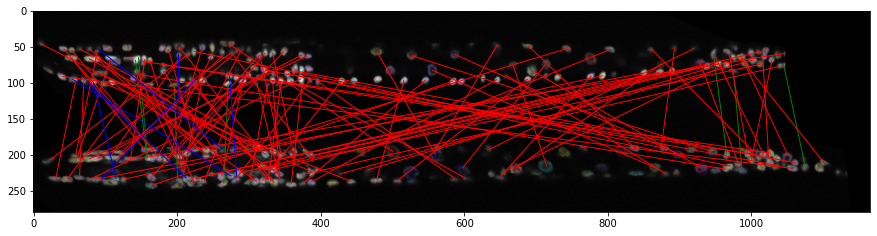

In [6]:
w2w_pm = get_w2wpm_from_clusters(WORMS[0], WORMS[1])   
plot_pm(X_SLICES[0], Z_MIN, Z_MAX, w2w_pm)

correct: 47
wrong: 43
noinfo: 15


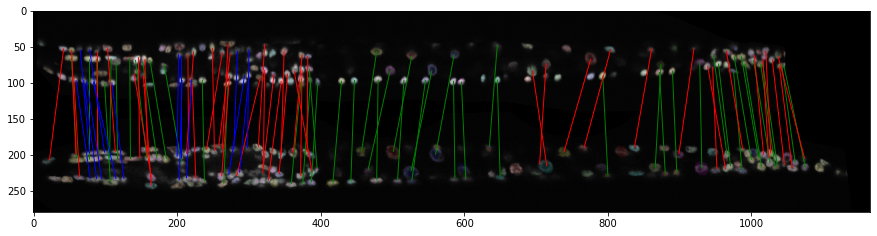

In [7]:
#CPM DATA
with open(DEFAULT_PATH.CPM_DATASET, 'rb') as f:
    bbb = pickle.load(f)
w2w_pm = bbb[f'{WORMS[0]}-{WORMS[1]}']
plot_pm(X_SLICES[0], Z_MIN, Z_MAX, w2w_pm)

172
correct: 48
wrong: 55
noinfo: 17


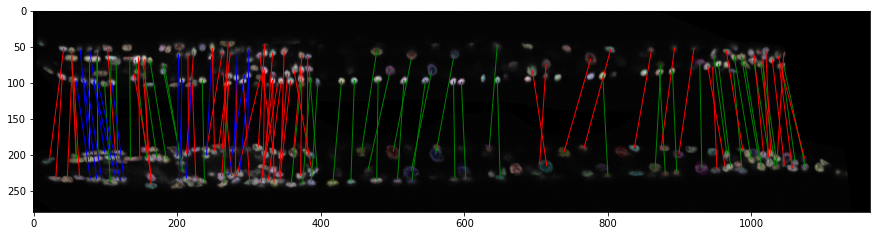

In [8]:
w2w_pm, acc = helper_get_pm_and_acc(WORMS[0], WORMS[1])
print(acc)
plot_pm(X_SLICES[0], Z_MIN, Z_MAX, w2w_pm)